In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize']:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)


paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

In [2]:
luminosities = pd.DataFrame()
for cl in ["ngc2682","ngc6774","praesepe","pleiades","hyades"]:
    lum = pd.read_csv(f"../StellarParameters/luminosities/{cl}_luminosities.csv")
    lum = lum[["EPIC","Lum_SED", "e_Lum_SED"]]
    lum.EPIC = lum.EPIC.astype(int)
    lum = lum.drop_duplicates()
    luminosities = luminosities.append(lum)

#df = df[(df.real == 1) & (df.note.isnull())]
print(luminosities.shape, luminosities.drop_duplicates().shape)
luminosities.head()

(3223, 3) (3223, 3)


,EPIC,Lum_SED,e_Lum_SED
0,211389428,4.423402e+31,8.249084e+30
1,211389537,1.445735e+32,1.781059e+31
2,211389716,8.802189e+32,2.385660e+32
3,211389931,4.774206e+31,8.714610e+30
4,211390158,1.252823e+33,2.372955e+32


In [3]:
ccol = dict(zip(['pleiades',"hyades","praesepe","ngc6774","ngc2682"],
                [["Pleiades","brown","x",135,25,25],
                 ["Hyades","orangered","*",690,160,100],
                 ["Praesepe","orange","d",750,3,7],
                 ["Rup 147", "green",r"$m$",2650,380,380],
                 ["M67","blue",">",3639,17,17]]))


In [5]:
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")
df = df.merge(luminosities, how="left", on="EPIC")
df = df[(df.Teff_median<6000) & (df.Teff_median>2500)]
hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
df = df[hasflares | wassearched]
df.columns.values

array(['istart', 'istop', 'cstart', 'cstop', 'tstart', 'tstop', 'ed_rec',
       'ed_rec_err', 'ampl_rec', 'dtp_tot', 'EPIC', 'C', 'real', 'length',
       'note', 'cluster', 'Lum_Kepler', 'e_Lum_Kepler', 'Teff_median',
       'Teff_std', 'todrop', 'double_peak', 'complex', 'multiperiod',
       'skybot', 'Lum_SED', 'e_Lum_SED'], dtype=object)

(861, 27)


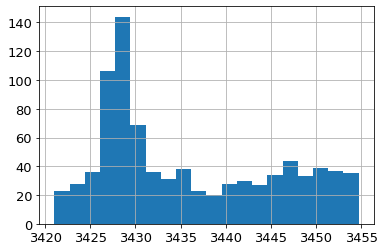

In [6]:
hasflares = (df.todrop.isnull())# & (df.real==1)
h = df[hasflares & (df.tstart > 3421) & (df.tstart < 3455)]
print(h.shape)
h.tstart.hist(bins=20)

In [7]:
hasflares = (df.real==1) & (df.todrop.isnull())
ffd = FFD(f=df[hasflares], ID="EPIC")

#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()
thresh

314.275882725327

In [8]:

df2 = copy.deepcopy(df)
df2["ed_rec"] = df.ed_rec * df.Lum_Kepler
ffd = FFD(f=df2[hasflares], ID="EPIC")


#---------- multiple stars 
ed, freq, counts = ffd.ed_and_freq(energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)

#ax.scatter(ffd.ed, ffd.freq, marker="^", c="c", label="correcting for multiple stars in sample")

cts = pd.Series(counts).value_counts()
thresh = cts[cts==1].sort_index().index.min()
Ethresh = cts[cts==1].sort_index().index.min()
Ethresh

3.312704642048483e+32

In [9]:
with open(f"{paperdir}values/FA_energy_thesh.txt", "w") as f:
    s = "$" + str(Ethresh)[:4] + r"\cdot 10^{" + f"{np.floor(np.log10(Ethresh)):.0f}" + r"}$ erg"
    f.write(s)
print(s)

$3.31\cdot 10^{32}$ erg


# FA

In [10]:
hasflares = (df.real==1) & (df.todrop.isnull())
abovethresh = df.ed_rec * df.Lum_Kepler > Ethresh
group = df[hasflares & abovethresh].groupby("EPIC")
FA = pd.DataFrame()
# calculate observing time per light curve
obstimelc = group.dtp_tot.unique().apply(lambda x: sum(x)) * 30 * 60
obstimelc.sort_values()

EPIC
212108286     4267800.0
212005503     4267800.0
212007145     4267800.0
212009944     4267800.0
211909798     4267800.0
                ...    
211917139    17031600.0
211887839    17031600.0
211929980    17031600.0
211845034    17031600.0
211950298    17031600.0
Name: dtp_tot, Length: 800, dtype: float64

In [11]:
ser =group.ed_rec.sum() * group.Lum_Kepler.first() / obstimelc / group.Lum_SED.first()
thr = Ethresh / obstimelc / group.Lum_SED.first()

FA["FA"] = ser
FA["EPIC"] = ser.index
FA["Teff_median"]  = group.Teff_median.first()
FA["cluster"]  = group.cluster.first()
FA.loc[(FA.FA < 0),"FA"] = 0.
FA = FA[~FA.FA.isnull()]
FA.sort_values(by="FA")
FA["FAmin"] = thr

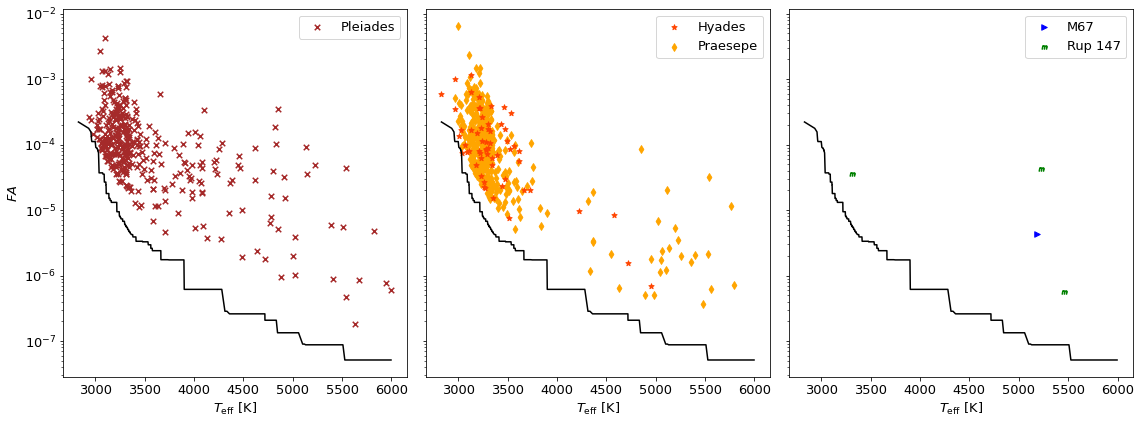

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(16,6), sharey=True, sharex=True)
for label, g in FA.groupby("cluster"):

    if label=="pleiades":
        ax[0].scatter(g.Teff_median,g.FA,label=ccol[label][0],s=30,c=ccol[label][1],marker=ccol[label][2])
        

    if label in ["praesepe","hyades"]:
        
        if label=="praesepe":
            ax[1].scatter(g.Teff_median,g.FA,label=ccol[label][0],s=30,c=ccol[label][1],marker=ccol[label][2],zorder=-1)
        else:
            ax[1].scatter(g.Teff_median,g.FA,label=ccol[label][0],s=30,c=ccol[label][1],marker=ccol[label][2])

    if label in ["ngc6774","ngc2682"]:
        ax[2].scatter(g.Teff_median,g.FA,label=ccol[label][0],s=30,c=ccol[label][1],marker=ccol[label][2])


FA = FA.sort_values(by="Teff_median",ascending=True)

for a in ax:
    a.plot(FA.Teff_median,FA.FAmin.rolling(window=150,win_type=None,min_periods=1).min(),c="k")
    a.set_yscale("log")
    a.set_xlabel(r"$T_\mathrm{eff}$ [K]")    
    a.legend()
    
ax[0].set_ylabel(r"$FA$")
plt.tight_layout()

# Compute cluster-wise observing time

In [13]:
df.shape

(8196, 27)

In [14]:
df["LC_time_years"] = df.dtp_tot / 2. / 24. / 365.25

cepic = df[["LC_time_years","EPIC","C", "Teff_median", "cluster"]].drop_duplicates() 
tobs = cepic.LC_time_years.sum()

print(f"Total observing time: {tobs:.2f} years!")


bins_T = pd.cut(cepic["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500","3500-3750","3750-4000","4000-5000","5000-6000"])
T = cepic.groupby([bins_T, "cluster"]).LC_time_years.sum().reset_index()
assert T.LC_time_years.sum() - tobs < 1e-10

Total observing time: 615.34 years!


# Compute cluster-wise FA 

In [33]:
cepicf = df[hasflares & abovethresh ][["LC_time_years","EPIC","C", 
                                       "Lum_SED", "e_Lum_SED",
                                       "Lum_Kepler", "e_Lum_Kepler",
                                       "Teff_median", "cluster",
                                       "ed_rec", "ed_rec_err"]].drop_duplicates()

bins_T = pd.cut(cepicf["Teff_median"],
                bins=[2500,3000,3250,3500,
                      3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500",
                        "3500-3750","3750-4000","4000-5000",
                        "5000-6000"])
FA = cepicf.groupby([bins_T, "cluster"]).ed_rec.sum().reset_index()

# Uncertainty on total ED is square root of sum of squares = simple error propagation
FA["ed_rec_err"] = np.sqrt(cepicf.groupby([bins_T, "cluster"]).ed_rec_err.apply(lambda x: x**2).sum())

#FA["num"] = cepicf.groupby([bins_T, "cluster"]).Lum_SED.count()

# Lum_SED
FA["Lum_SED"] = cepicf.groupby([bins_T, "cluster"]).Lum_SED.median().values
# Uncertainty on luminosity Lum_SED is standard deviation in Teff bin
FA["e_Lum_SED"] = cepicf.groupby([bins_T, "cluster"]).Lum_SED.std().values

# Lum_Kepler
FA["Lum_Kepler"] = cepicf.groupby([bins_T, "cluster"]).Lum_Kepler.median().values
# Uncertainty on luminosity Lum_SED is standard deviation in Teff bin
FA["e_Lum_Kepler"] = cepicf.groupby([bins_T, "cluster"]).Lum_Kepler.std().values

#FA.loc[FA.e_Lum_Kepler.isnull(), "e_Lum_Kepler"] = cepicf[cepicf.cluster == FA.loc[FA.e_Lum_Kepler.isnull(), "cluster"]]# &
                                                         # cepicf.Teff_median ==

#FA.loc[FA.e_Lum_Kepler.isnull(),"e_Lum_Kepler"] 

# Merge cluster-wise observing times. It is in another table  because it includes light curves without flares
FA = FA.merge(T, on=["Teff_median", "cluster"],how="left")

# convert observing time from years to seconds
obstime = T.LC_time_years * 3600 * 24 * 365.25

# FA = E_Kepler / (Lum_SED * obstime) Flaring activity for a median star in the Teff bin
FA["FA"] = FA.ed_rec * FA.Lum_Kepler / FA.Lum_SED / obstime

# FA err is calculated by simple error propagation
FA["FAerr"] = 1. / obstime * np.sqrt((FA.ed_rec_err * FA.Lum_Kepler / FA.Lum_SED)**2 + 
                                     (FA.ed_rec * FA.e_Lum_Kepler / FA.Lum_SED)**2 +
                                     (FA.ed_rec * FA.Lum_Kepler / FA.Lum_SED**2 * FA.e_Lum_SED)**2)
# Add some columns
FA["age"] = FA.cluster.apply(lambda x: ccol[x][3])
FA["age_uperr"] = FA.cluster.apply(lambda x: ccol[x][4])
FA["age_loerr"] = FA.cluster.apply(lambda x: ccol[x][5])
FA["cluster"] = FA.cluster.apply(lambda x: ccol[x][0])
FA["Tmin"] = FA.Teff_median.apply(lambda x: int(x.split("-")[0]))
FA["Tmax"] = FA.Teff_median.apply(lambda x: int(x.split("-")[1]))
FA["Tmid"] = ((FA.Tmax.astype(float) + FA.Tmin.astype(float)) / 2).astype(int)
FA["Tmid_err"] = ((FA.Tmax.astype(float) - FA.Tmin.astype(float)) / 2).astype(int)

FA.loc[(FA.cluster == "M67")&(FA.Teff_median == "5000-6000"),"FAerr"] = sig_m67
FA

,Teff_median,cluster,ed_rec,ed_rec_err,Lum_SED,e_Lum_SED,Lum_Kepler,e_Lum_Kepler,LC_time_years,FA,FAerr,age,age_uperr,age_loerr,Tmin,Tmax,Tmid,Tmid_err
0,2500-3000,Hyades,32570.270217,1062.734075,4.306733e+29,1.179898e+29,1.690013e+29,4.758159e+28,3.201118,1.265196e-04,4.987343e-05,690,160,100,2500,3000,2750,250
1,2500-3000,M67,NaN,1062.734075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3639,17,17,2500,3000,2750,250
2,2500-3000,Rup 147,NaN,1062.734075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2650,380,380,2500,3000,2750,250
3,2500-3000,Pleiades,24882.480453,1062.734075,3.544552e+29,3.718082e+28,1.386438e+29,1.500699e+28,9.734428,3.168243e-05,4.963479e-06,135,25,25,2500,3000,2750,250
4,2500-3000,Praesepe,11077.696671,1062.734075,4.999600e+29,6.668206e+28,1.973865e+29,2.710067e+28,4.740475,2.923519e-05,6.259532e-06,750,3,7,2500,3000,2750,250
5,3000-3250,Hyades,85112.151417,1062.734075,1.922771e+30,5.361236e+29,7.841857e+29,2.221002e+29,11.681269,9.416490e-05,3.744369e-05,690,160,100,3000,3250,3125,125
6,3000-3250,M67,NaN,1062.734075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3639,17,17,3000,3250,3125,125
7,3000-3250,Rup 147,NaN,1062.734075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2650,380,380,3000,3250,3125,125
8,3000-3250,Pleiades,613566.310028,1062.734075,1.379413e+30,4.626939e+29,5.592365e+29,1.918835e+29,59.470853,1.325423e-04,6.359881e-05,135,25,25,3000,3250,3125,125
9,3000-3250,Praesepe,918386.734758,1062.734075,1.701362e+30,5.046081e+29,6.903147e+29,2.096333e+29,123.571070,9.555538e-05,4.056183e-05,750,3,7,3000,3250,3125,125


/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


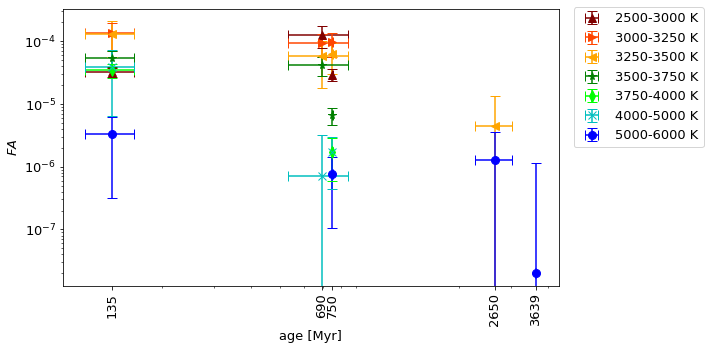

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
Tcols = {"2750":["^","maroon"],
         "3125":[">","orangered"],
         "3375":["<","orange"],
         "3625":["*","green"],
         "3875":["d","lime"],
         "4500":["x","c"],
         "5500":["o","blue"],}
for label, g in FA.groupby("Tmid"):
 
    g.loc[:,"cluster"] = pd.Categorical(g.cluster, 
                      categories=["Pleiades","Hyades","Praesepe","Rup 147", "M67"],
                      ordered=True)
    g = g.sort_values(by="cluster")
    ax.errorbar(x="age", xerr="age_uperr",y="FA",yerr="FAerr",capsize=5,data=g,
           label=f"{g.Tmin.iloc[0]}-{g.Tmax.iloc[0]} K", c=Tcols[str(label)][1],
          fmt=Tcols[str(label)][0],markersize=8)#s=120,)#
    

ax.set_xlabel("age [Myr]")
ax.set_ylabel(r"$FA$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xticks(FA.age.astype(float).unique())
ax.set_xticklabels(labels=FA.age.unique(), rotation=90)
ax.legend(loc=(1.03,.5))
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_FA_T_age_Ethresh.png", dpi=300)
plt.savefig(f"{paperdir}pics/FA/FA_T_age_Ethresh.png", dpi=300)

In [32]:
m67 = df[(df.cluster=="ngc2682") & (df.real==1) & (df.Teff_median<6000)]
t =  (m67.dtp_tot * 30. * 60.).values[0]
L = m67.Lum_SED.values[0]
eL = m67.e_Lum_SED.values[0]
E = (m67.ed_rec * m67.Lum_Kepler).values[0]
eE = np.sqrt((m67.ed_rec_err*m67.Lum_Kepler)**2 + (m67.ed_rec*m67.e_Lum_Kepler)**2).values[0]

In [29]:
t, L, eL, E, eE

(6202800.0,
 2.341976592647924e+32,
 4.251047383207859e+31,
 6.248251125377269e+33,
 1.1747189160325071e+33)

In [30]:
sig_m67 = np.sqrt(eE**2 + (E/L*eL)**2)/t/L
sig_m67

1.1240396858565568e-06